In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [26]:
data = pd.read_csv('Loan_Data.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
ds = data.copy()
ds.drop('Loan_ID', axis = 1, inplace = True)

In [4]:
ds.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
#ds['Dependents'].sample(200).values
#ds['Dependents'] = ds['Dependents'].str.replace('+', '')
#ds['Dependents'] = pd.to_numeric(ds['Dependents'], errors = 'coerce')
#ds['Dependents'].dtypes

In [6]:
cat = ds.select_dtypes(exclude = 'number')
num = ds.select_dtypes(include = 'number')

print('Numerical Data')
display(num.head())
print(f'\n\nCategorical Data')
display(cat.head())

Numerical Data


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0




Categorical Data


,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y


In [7]:
for i in ds.columns:
    if ((ds[i].isnull().sum() / len(ds)) * 100) < 30:
        if ds[i].dtypes != 'O':
            ds[i].fillna(ds[i].median(), inplace = True)
        else:
            ds[i].fillna(ds[i].mode()[0], inplace = True)
    else:
      ds.drop(i, axis = 1, inplace =True)

ds.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [8]:
#to know the columns to scale
cols_to_scale = []
for i in num.columns:
    if ds[i].describe()[2] > 1500:
        cols_to_scale.append(i)


cols_to_scale

['ApplicantIncome', 'CoapplicantIncome']

In [9]:
# SCALE THE NUMERICAL COLUMNS
from sklearn.preprocessing import StandardScaler
import joblib

scaled = {}

for i in cols_to_scale[:]:
    scale = StandardScaler()
    ds[i] = scale.fit_transform(ds[[i]])
    joblib.dump(scale, open(f'{i}_scaler.pkl', 'wb'))
    scaled[i + '_scaler']=scale

scaled

{'ApplicantIncome_scaler': StandardScaler(),
 'CoapplicantIncome_scaler': StandardScaler()}

In [10]:
# to encode categorical datas
from sklearn.preprocessing import LabelEncoder

encoded = {}
for i in cat.columns:
    encode = LabelEncoder()
    ds[i] = encode.fit_transform(ds[i])
    joblib.dump(encode, open(f'{i}_encoder.pkl', 'wb'))
    encoded[i + 'encoder'] = encode

encoded

{'Genderencoder': LabelEncoder(),
 'Marriedencoder': LabelEncoder(),
 'Dependentsencoder': LabelEncoder(),
 'Educationencoder': LabelEncoder(),
 'Self_Employedencoder': LabelEncoder(),
 'Property_Areaencoder': LabelEncoder(),
 'Loan_Statusencoder': LabelEncoder()}

In [11]:
ds.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,0.072991,-0.554487,128.0,360.0,1.0,2,1
1,1,1,1,0,0,-0.134412,-0.038732,128.0,360.0,1.0,0,0
2,1,1,0,0,1,-0.393747,-0.554487,66.0,360.0,1.0,2,1
3,1,1,0,1,0,-0.462062,0.251980,120.0,360.0,1.0,2,1
4,1,0,0,0,0,0.097728,-0.554487,141.0,360.0,1.0,2,1


In [25]:
%pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

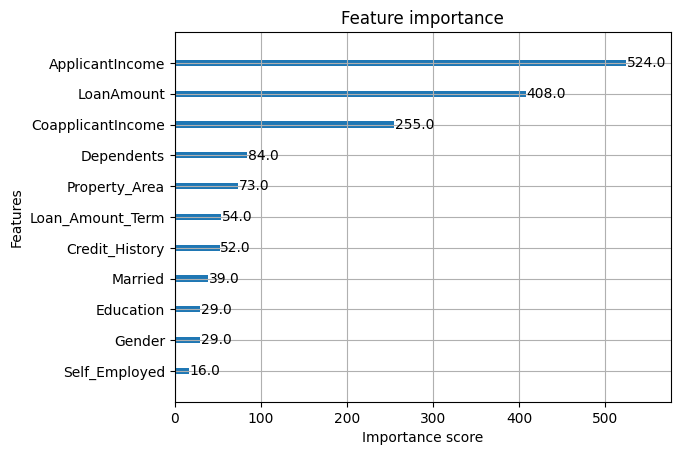

In [16]:
import matplotlib.pyplot as plt
import xgboost as xgb

model = xgb.XGBClassifier()

x= ds.drop('Loan_Status', axis = 1)
y = ds.Loan_Status

model.fit(x, y)

#Print feature importance scores
xgb.plot_importance(model, importance_type = 'weight')

In [17]:
sel_cols = ['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', 'Dependents', 'Property_Area',
            'Credit_History', 'Loan_Amount_Term', 'Loan_Status']

new_data = ds[sel_cols]
new_data.head()

,ApplicantIncome,LoanAmount,CoapplicantIncome,Dependents,Property_Area,Credit_History,Loan_Amount_Term,Loan_Status
0,0.072991,128.0,-0.554487,0,2,1.0,360.0,1
1,-0.134412,128.0,-0.038732,1,0,1.0,360.0,0
2,-0.393747,66.0,-0.554487,0,2,1.0,360.0,1
3,-0.462062,120.0,0.251980,0,2,1.0,360.0,1
4,0.097728,141.0,-0.554487,0,2,1.0,360.0,1


In [18]:
#------ Modelling ---------
from sklearn.model_selection import train_test_split

x = new_data.drop('Loan_Status', axis = 1)
y = new_data.Loan_Status

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.10)
print(f'Xtrain: {xtrain.shape}')
print(f'Xtest: {xtest.shape}')
print(f'Ytrain: {ytrain.shape}')
print(f'Ytest: {ytest.shape}')

Xtrain: (552, 7)
Xtest: (62, 7)
Ytrain: (552,)
Ytest: (62,)


,ApplicantIncome,LoanAmount,CoapplicantIncome,Dependents,Property_Area,Credit_History,Loan_Amount_Term,Loan_Status
153,-0.511538,113.0,-0.554487,2,0,1.0,360.0,0
14,-0.672414,17.0,-0.183061,2,2,1.0,120.0,1
190,-0.084937,48.0,-0.554487,0,0,1.0,360.0,1
219,-0.183560,127.0,0.260530,2,1,1.0,360.0,1
361,-0.066097,236.0,0.699675,2,1,1.0,360.0,1
...,...,...,...,...,...,...,...,...
585,-0.183560,172.0,0.471552,1,0,1.0,84.0,0
308,2.429453,480.0,-0.554487,0,0,1.0,360.0,0
277,-0.376873,80.0,-0.109870,0,2,1.0,360.0,1
514,0.067421,311.0,0.699333,0,0,1.0,360.0,0


<Axes: xlabel='Loan_Status', ylabel='count'>

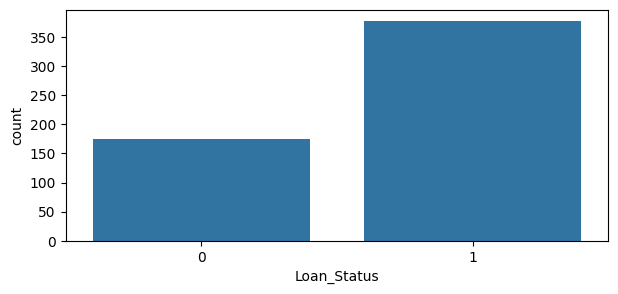

In [19]:
training_data = pd.concat([xtrain, ytrain], axis = 1)
plt.figure(figsize = (7,3))

display(training_data)
sns.countplot(x = training_data['Loan_Status'])

,ApplicantIncome,LoanAmount,CoapplicantIncome,Dependents,Property_Area,Credit_History,Loan_Amount_Term,Loan_Status
153,-0.511538,113.0,-0.554487,2,0,1.0,360.0,0
600,-0.817072,350.0,13.696173,3,2,1.0,180.0,0
150,0.143108,118.0,-0.554487,0,0,0.0,360.0,0
517,-0.381624,123.0,0.061136,0,1,0.0,360.0,0
366,-0.475660,96.0,-0.554487,0,1,1.0,480.0,0
...,...,...,...,...,...,...,...,...
433,-0.487947,143.0,0.245823,0,1,1.0,360.0,1
604,1.080680,496.0,-0.554487,1,1,1.0,360.0,1
570,-0.325432,186.0,0.044036,1,2,1.0,360.0,1
109,-0.545941,94.0,-0.296609,3,1,1.0,480.0,1


<Axes: xlabel='Loan_Status', ylabel='count'>

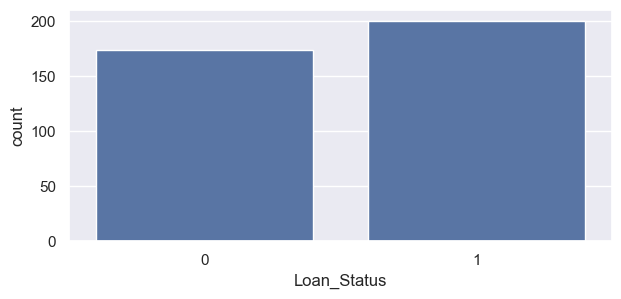

In [20]:
class0 = training_data.loc[training_data['Loan_Status'] == 0]
class1 = training_data.loc[training_data['Loan_Status'] == 1]

new_class1 = class1.sample(200)

new_training_data = pd.concat([class0, new_class1], axis = 0)

display(new_training_data)
plt.figure(figsize = (7,3))
sns.set(style= 'darkgrid')
sns.countplot(x = new_training_data['Loan_Status'])

In [21]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
xgb_model = xgb.XGBClassifier()

x = new_training_data.drop('Loan_Status', axis = 1)
y = new_training_data['Loan_Status']

xgb_model.fit(x, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
from sklearn.metrics import classification_report

cv = xgb_model.predict(xtest)
print(classification_report(cv, ytest))

              precision    recall  f1-score   support

           0       0.67      0.41      0.51        29
           1       0.61      0.82      0.70        33

    accuracy                           0.63        62
   macro avg       0.64      0.62      0.61        62
weighted avg       0.64      0.63      0.61        62



In [23]:
#Model Saving
joblib.dump(xgb_model, open('loanpredictionmodel.pkl','wb'))

In [24]:
xtrain.columns

Index(['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', 'Dependents',
       'Property_Area', 'Credit_History', 'Loan_Amount_Term'],
      dtype='object')